In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


# Load the data
data = pd.read_csv('hotel_booking.csv')
pre_processed_data=data

In [31]:
import Algoritmos
from importlib import reload
reload(Algoritmos)
alg=Algoritmos.Algoritmos()


In [32]:
# Display the number of missing values in each column sorted in ascending order
print(f"Number of nulls per column: {data.isnull().sum().sort_values(ascending=False)}")

print(f"Number of duplicate rows: {data.duplicated().sum()}")


Number of nulls per column: company                           112593
agent                              16340
country                              488
children                               4
hotel                                  0
booking_changes                        0
deposit_type                           0
days_in_waiting_list                   0
customer_type                          0
adr                                    0
reserved_room_type                     0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
reservation_status_date                0
name                                   0
email                                  0
phone-number                           0
assigned_room_type                     0
previous_bookings_not_canceled         0
is_canceled                            0
previous_cancellations                 0
is_repeated_guest                      0
distribution_channel         

In [33]:
#adicionar nova coluna 
data['origin_reservasion'] = data.apply(
    lambda row: 'agent' if pd.notnull(row['agent']) 
                 else ('company' if pd.notnull(row['company']) 
                       else 'himself'), 
    axis=1
)
#mudar o data type para int
data['children'] = data['children'].fillna(0).astype(int)
data['children'] = data['children'].astype(int)

#coluna que verifica que se o quarto que foi reservado foi o que teve
data['room_type_match'] = (data['reserved_room_type'] == data['assigned_room_type']).astype(int)

In [34]:
#Elimnate columns that are not useful
columns_to_drop = [
    'name', 
    'email', 
    'phone-number', 
    'credit_card', 
    'company', 
    'agent', 
    'reservation_status', 
    'reservation_status_date'
]

data = data.drop(columns=columns_to_drop)

In [35]:
# Assign a placeholder for missing values
data.fillna(value={'country': 'Missing'}, inplace=True)
data.info()
print(f"\nNumber of nulls per column:\n{data.isnull().sum().sort_values(ascending=False)}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  int32  
 11  babies                          119390 non-null  int64  
 12  meal            

In [36]:
# Verify if have duplicate rows
print(f"Antes de remover duplicadas: {data.shape[0]} linhas")
data.drop_duplicates(inplace=True)
print(f"Depois de remover duplicadas: {data.shape[0]} linhas")


# Check for unique values
unique_values = data.nunique()
print(f"\nUnique values:\n{unique_values}")

Antes de remover duplicadas: 119390 linhas
Depois de remover duplicadas: 87117 linhas

Unique values:
hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            178
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
d

In [37]:
# Separate columns into categorical and numerical
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = data.select_dtypes(include=['int32','int64', 'float64']).columns.tolist()

# Display the separated columns
print("Categorical Columns:")
print(categorical_columns)
print("\nNumerical Columns:")
print(numerical_columns)

Categorical Columns:
['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'origin_reservasion']

Numerical Columns:
['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'room_type_match']


### Verificar correlações com a coluna objetivo "is_canceled"

In [38]:
# Aplicar FunctionAnova
continuous_columns = numerical_columns
continuous_columns = [col for col in continuous_columns if col != 'is_canceled']

Anova = alg.FunctionAnova(data, "is_canceled", continuous_columns)
print(f"\nColunas selecionadas por anova:\n{Anova}")

##### ANOVA Results ##### 

lead_time is correlated with is_canceled | P-Value: 0.0
arrival_date_year is correlated with is_canceled | P-Value: 5.011297830909459e-153
arrival_date_week_number is NOT correlated with is_canceled | P-Value: 0.7266318921971181
arrival_date_day_of_month is NOT correlated with is_canceled | P-Value: 0.12940649034486013
stays_in_weekend_nights is correlated with is_canceled | P-Value: 1.3965026725723162e-71
stays_in_week_nights is correlated with is_canceled | P-Value: 2.675588715881443e-134
adults is correlated with is_canceled | P-Value: 8.291137474655373e-131
children is correlated with is_canceled | P-Value: 5.411381042729974e-91
babies is correlated with is_canceled | P-Value: 1.3983154099487818e-09
is_repeated_guest is correlated with is_canceled | P-Value: 3.4281665806940645e-153
previous_cancellations is correlated with is_canceled | P-Value: 4.389179073267092e-51
previous_bookings_not_canceled is correlated with is_canceled | P-Value: 6.0527493050835

### Comentário sobre os Resultados da ANOVA

A análise de variância (ANOVA) foi realizada para investigar a relação entre diversas variáveis contínuas e a variável categórica `is_canceled`. Essa análise é útil para identificar quais variáveis possuem uma influência significativa sobre a decisão de cancelamento de reserva.

### Resumo dos Resultados

1. **Variáveis Correlacionadas com `is_canceled`**:
   - **lead_time**: Valor-p de 0.0, indicando uma forte correlação entre o tempo de antecedência da reserva e a decisão de cancelamento.
   - **arrival_date_year**: A correlação com o cancelamento é significativa, com um valor-p extremamente baixo de \(5.01 \times 10^{-153}\).
   - **stays_in_weekend_nights**: Valor-p de \(1.40 \times 10^{-71}\), indicando que a quantidade de noites de fim de semana influenciam o cancelamento.
   - **stays_in_week_nights**: Com um valor-p de \(2.68 \times 10^{-134}\), a quantidade de noites na semana tem uma correlação significativa com cancelamentos.
   - **adults**: Valor-p de \(8.29 \times 10^{-131}\), indicando que o número de adultos na reserva influencia a probabilidade de cancelamento.
   - **children**: Apresenta um valor-p muito baixo (\(5.41 \times 10^{-91}\)), sugerindo uma correlação significativa.
   - **babies**: Embora o valor-p seja mais alto (\(1.39 \times 10^{-9}\)), a presença de bebês ainda tem um efeito significativo.
   - **is_repeated_guest**: Valor-p de \(3.43 \times 10^{-153}\), sugerindo que hóspedes repetidos têm uma relação relevante com a taxa de cancelamento.
   - **previous_cancellations**: Com um valor-p de \(4.39 \times 10^{-51}\), o número de cancelamentos anteriores é um forte indicador.
   - **previous_bookings_not_canceled**: Também significativo, com um valor-p de \(6.05 \times 10^{-53}\).
   - **booking_changes**: Valor-p de \(1.54 \times 10^{-165}\), indicando que alterações na reserva estão correlacionadas com o cancelamento.
   - **adr**: O valor médio diário (ADR) é significativo, com um valor-p de \(1.33 \times 10^{-321}\), sugerindo que o preço médio tem influência.
   - **required_car_parking_spaces**: Valor-p de 0.0, indicando que a necessidade de vagas de estacionamento impacta a decisão.
   - **total_of_special_requests**: Valor-p extremamente baixo (\(2.71 \times 10^{-270}\)), mostrando que pedidos especiais influenciam a decisão de cancelamento.
   - **room_type_match**: Com um valor-p de 0.0, a correspondência entre o quarto reservado e o quarto designado afeta o cancelamento.

2. **Variáveis Não Correlacionadas**:
   - **arrival_date_week_number**: Com um valor-p de 0.73, essa variável não apresenta uma correlação significativa.
   - **arrival_date_day_of_month**: Valor-p de 0.13, indicando que o dia específico do mês de chegada não tem um impacto significativo.
   - **days_in_waiting_list**: Com um valor-p de 0.63, o tempo em lista de espera não mostra correlação significativa.

### Conclusões

Os resultados da ANOVA sugerem que várias variáveis contínuas estão fortemente correlacionadas com a variável `is_canceled`, indicando que podem ser fatores importantes para a previsão de cancelamentos. Essas variáveis podem fornecer insights para o setor hoteleiro e ajudar a criar políticas de reserva que considerem os fatores que mais influenciam a decisão de cancelamento. As variáveis que não apresentaram correlação significativa podem ser candidatas à remoção no modelo final, simplificando a análise e reduzindo o risco de sobreajuste.


In [10]:
#Aplicação da função FunctionChisq para saber se ha alguma correlação entre colunas categóricas
Chisq = alg.FunctionChisq(data, 'is_canceled', categorical_columns)
print(f"\nColunas selecionadas por Chisq:\n{Chisq}")

hotel is correlated with is_canceled | P-Value: 2.2758007400530205e-98
arrival_date_month is correlated with is_canceled | P-Value: 1.2409888616987342e-132
meal is correlated with is_canceled | P-Value: 4.388419863615188e-78
country is correlated with is_canceled | P-Value: 0.0
market_segment is correlated with is_canceled | P-Value: 0.0
distribution_channel is correlated with is_canceled | P-Value: 0.0
reserved_room_type is correlated with is_canceled | P-Value: 4.076653222633679e-62
assigned_room_type is correlated with is_canceled | P-Value: 3.3364918855179735e-155
deposit_type is correlated with is_canceled | P-Value: 0.0
customer_type is correlated with is_canceled | P-Value: 0.0
origin_reservasion is correlated with is_canceled | P-Value: 0.0

Colunas selecionadas por Chisq:
['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'origin_reservasion']


### Comentário sobre os Resultados do Teste Qui-Quadrado

Os resultados do teste Qui-Quadrado revelam informações importantes sobre a relação entre as variáveis categóricas e a variável `is_canceled`, que indica se uma reserva foi cancelada. A seguir, vamos analisar os resultados e discutir suas implicações.

### Resumo dos Resultados

1. **Variáveis Correlacionadas com `is_canceled`**:
   - **hotel**: O valor-p de \(2.28 \times 10^{-98}\) sugere uma correlação extremamente significativa, indicando que o hotel selecionado tem um impacto importante na probabilidade de cancelamento.
   - **arrival_date_month**: Com um valor-p de \(1.24 \times 10^{-132}\), este mês de chegada é altamente correlacionado com os cancelamentos, sugerindo que a época do ano pode influenciar as decisões dos hóspedes.
   - **meal**: O valor-p de \(4.39 \times 10^{-78}\) indica que o tipo de refeição escolhida também tem uma relação significativa com o cancelamento de reservas.
   - **country**: A variável país apresenta um valor-p de 0.0, indicando uma correlação forte e relevante com o cancelamento, possivelmente refletindo diferenças culturais ou de expectativas entre os hóspedes de diferentes nacionalidades.
   - **market_segment**: O segmento de mercado apresenta uma correlação significativa, com valor-p de 0.0, sugerindo que a origem da reserva pode afetar as taxas de cancelamento.
   - **distribution_channel**: Com um valor-p de 0.0, esta variável está diretamente relacionada com a taxa de cancelamento, o que pode indicar a influência do canal de reserva na decisão do hóspede.
   - **reserved_room_type**: O tipo de quarto reservado tem um valor-p de \(4.08 \times 10^{-62}\), indicando uma relação significativa com o cancelamento.
   - **assigned_room_type**: Com um valor-p de \(3.34 \times 10^{-155}\), a relação entre o tipo de quarto atribuído e o cancelamento é extremamente significativa.
   - **deposit_type**: O tipo de depósito apresenta um valor-p de 0.0, mostrando uma correlação clara com o cancelamento.
   - **customer_type**: Esta variável também tem um valor-p de 0.0, o que indica que o tipo de cliente está fortemente relacionado com as taxas de cancelamento.
   - **origin_reservasion**: Com um valor-p de 0.0, a forma como a reserva foi feita (por agente, empresa ou diretamente) tem uma relação significativa com o cancelamento.

### Conclusões

Os resultados do teste Qui-Quadrado confirmam que diversas variáveis categóricas estão significativamente correlacionadas com o cancelamento de reservas. A análise das variáveis selecionadas permite que os gerentes de hotéis identifiquem padrões que podem informar políticas de reserva, promoções e melhorias no atendimento ao cliente, potencialmente resultando em uma diminuição das taxas de cancelamento.


In [11]:
#Aplicar lasso_regularization
data_dummies=data
data_dummies = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data_dummies_X = data_dummies.drop(columns=['is_canceled'])
data_dummies_y = data_dummies['is_canceled']   
lasso_regularization=alg.lasso_regularization(data_dummies_X,data_dummies_y)

Number of features which coefficient was shrank to zero:  12
Index(['arrival_date_week_number', 'country_ATA', 'country_BDI', 'country_DMA',
       'country_GLP', 'country_GUY', 'country_MRT', 'country_MWI',
       'country_NAM', 'country_NPL', 'country_VGB',
       'market_segment_Undefined'],
      dtype='object')


### Comentário sobre os Resultados da Regularização Lasso

A regularização Lasso é uma técnica poderosa utilizada em modelos de regressão que permite tanto a seleção de variáveis quanto a regularização do modelo, ajudando a evitar o sobreajuste. A seguir, vamos interpretar os resultados obtidos após a aplicação da regularização Lasso aos dados.

### Resumo dos Resultados

1. **Colunas Selecionadas pelo Lasso**:
   - O modelo de regularização Lasso identificou um total de **12 colunas** cujos coeficientes foram reduzidos a zero, o que significa que essas variáveis foram consideradas irrelevantes para a predição da variável `is_canceled`. As colunas identificadas são:
     - **arrival_date_week_number**: O número da semana de chegada foi eliminado, sugerindo que esta informação não contribui para prever cancelamentos.
     - **country_ATA, country_BDI, country_DMA, country_GLP, country_GUY, country_MRT, country_MWI, country_NAM, country_NPL, country_VGB**: A presença de várias variáveis relacionadas a países específicos (ATA, BDI, DMA, GLP, GUY, MRT, MWI, NAM, NPL, VGB) também foram desconsideradas, indicando que esses países não têm um impacto significativo nas taxas de cancelamento.
     - **market_segment_Undefined**: Essa variável, que representa um segmento de mercado indefinido, foi eliminada do modelo, o que sugere que a falta de categorização clara não é informativa para prever cancelamentos.

### Conclusões

Os resultados da regularização Lasso destacam a eficácia desta técnica na simplificação do modelo, eliminando variáveis que não contribuem para a predição do cancelamento de reservas. A análise e a otimização contínua das variáveis incluídas no modelo são fundamentais para desenvolver estratégias eficazes para reduzir as taxas de cancelamento.


In [12]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Convert non-numeric columns to values
for column in categorical_columns:
    # Convert the column to string type to avoid type conflicts
    data[column] = data[column].astype(str)
    # Apply LabelEncoder
    data[column] = label_encoder.fit_transform(data[column])

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 87117 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87117 non-null  int32  
 1   is_canceled                     87117 non-null  int64  
 2   lead_time                       87117 non-null  int64  
 3   arrival_date_year               87117 non-null  int64  
 4   arrival_date_month              87117 non-null  int32  
 5   arrival_date_week_number        87117 non-null  int64  
 6   arrival_date_day_of_month       87117 non-null  int64  
 7   stays_in_weekend_nights         87117 non-null  int64  
 8   stays_in_week_nights            87117 non-null  int64  
 9   adults                          87117 non-null  int64  
 10  children                        87117 non-null  int32  
 11  babies                          87117 non-null  int64  
 12  meal                            8711

Correlação com is_canceled:
is_canceled                       1.000000
room_type_match                   0.213516
market_segment                    0.183282
lead_time                         0.182788
distribution_channel              0.150193
deposit_type                      0.136551
adr                               0.129352
country                           0.092866
arrival_date_year                 0.089102
stays_in_week_nights              0.083414
adults                            0.082310
children                          0.068458
stays_in_weekend_nights           0.060559
previous_cancellations            0.050904
reserved_room_type                0.049882
meal                              0.045371
arrival_date_day_of_month         0.005138
days_in_waiting_list              0.001609
arrival_date_week_number          0.001185
babies                           -0.020515
customer_type                    -0.034979
arrival_date_month               -0.045452
previous_bookings_not_canc

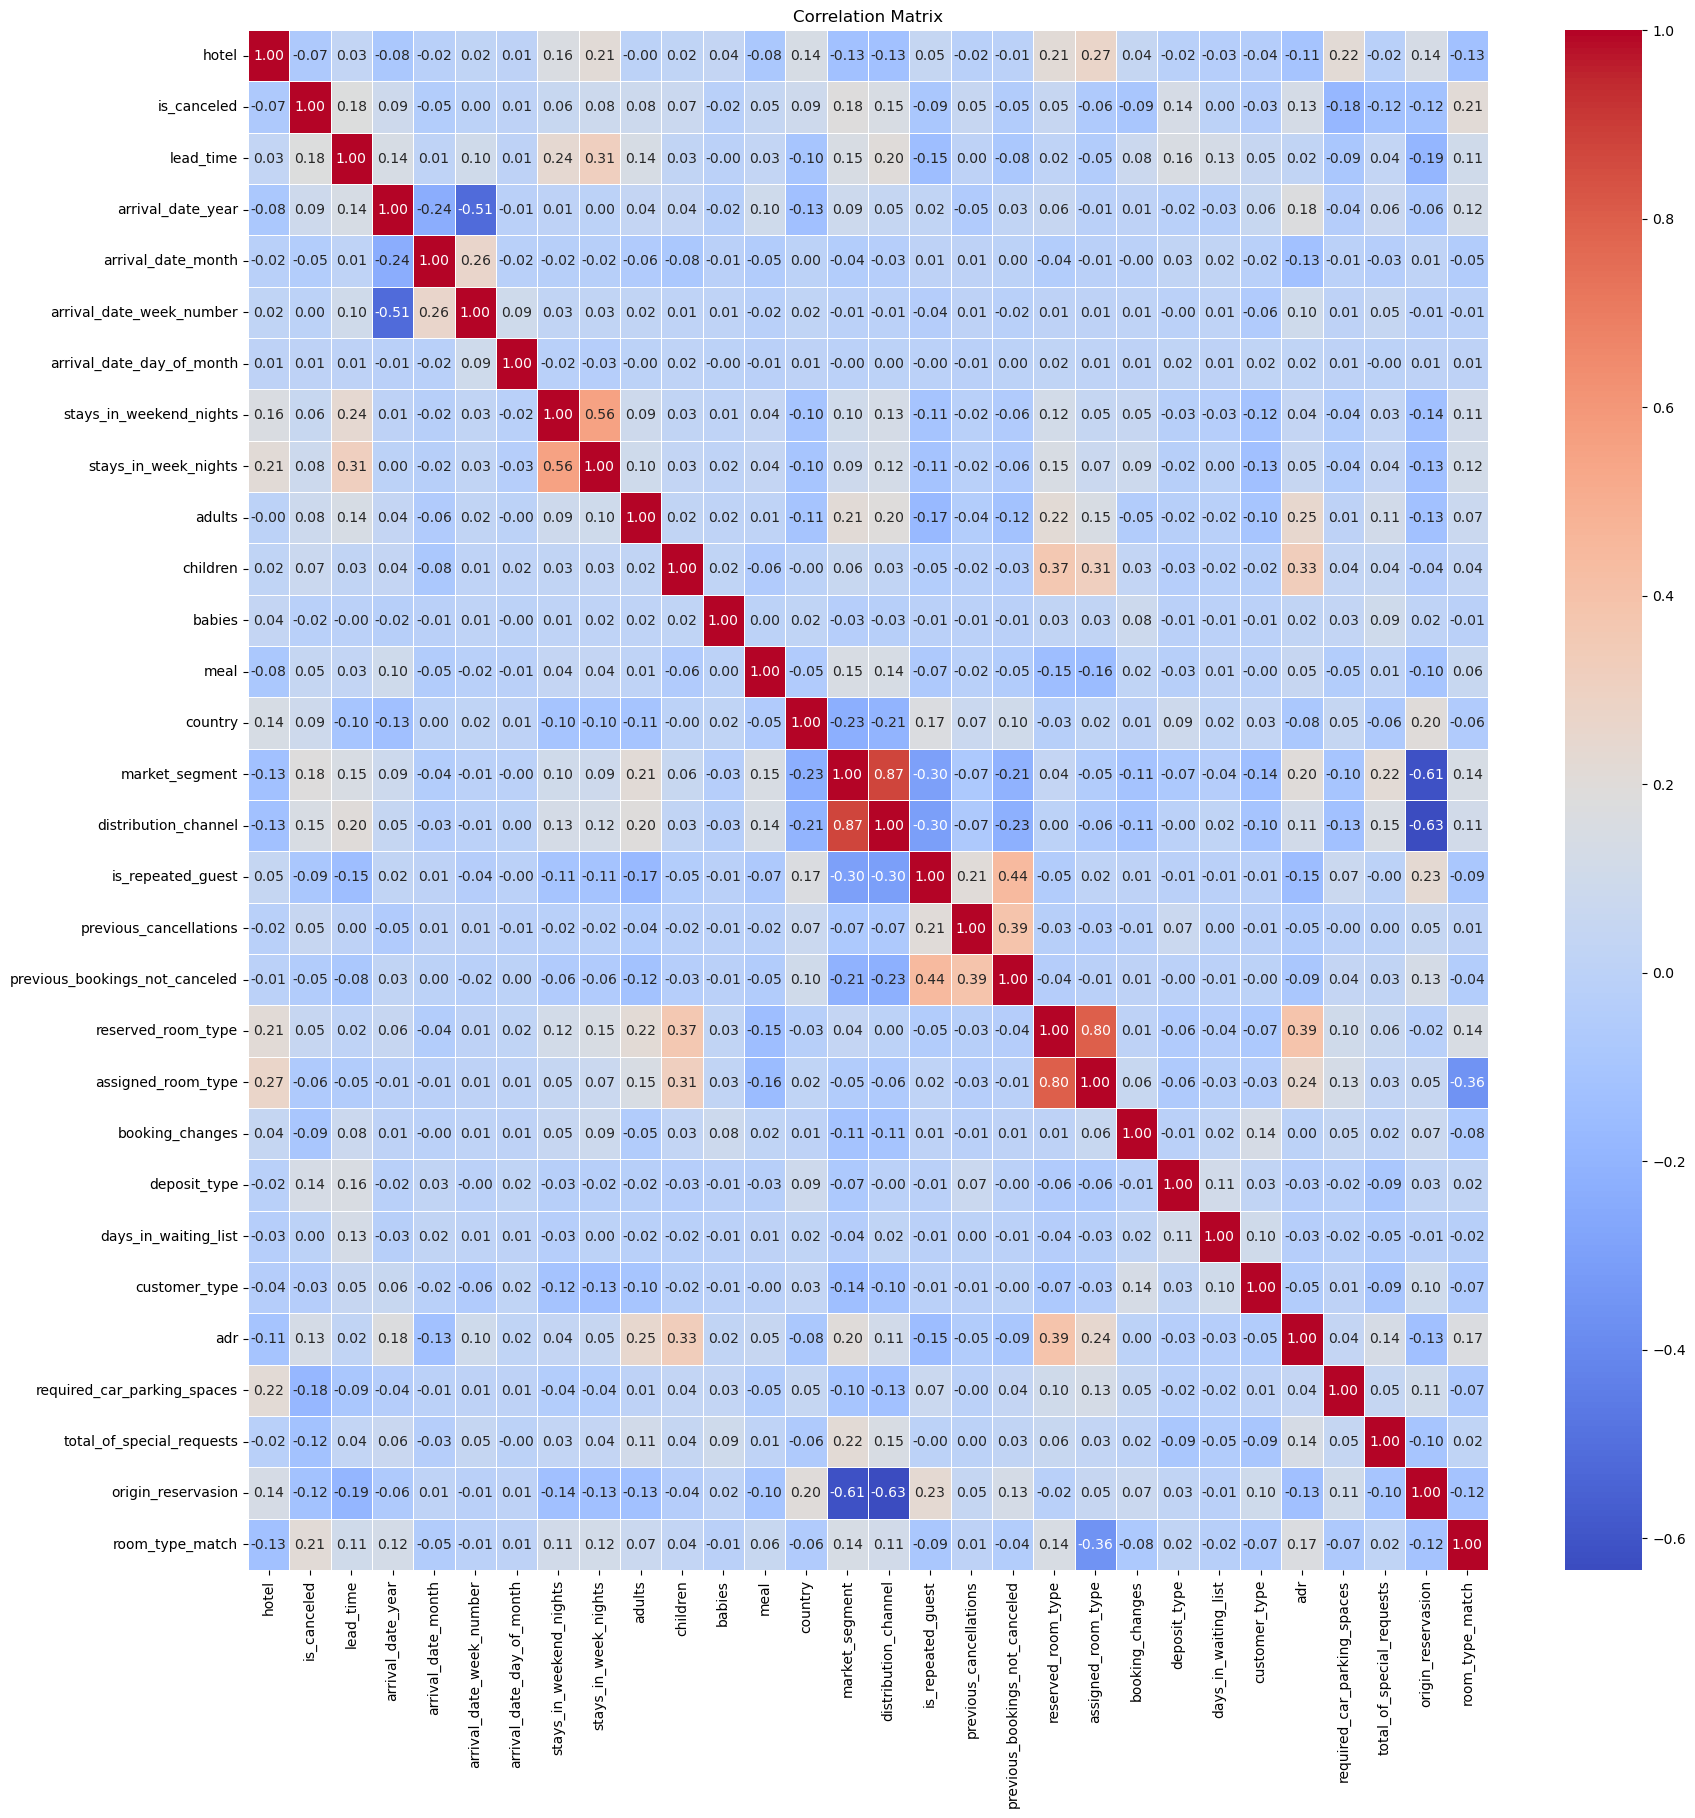

In [28]:
# Let's check the correlation between variables 
numerical_columns = data.select_dtypes(include=['int32','int64', 'float64']).columns.tolist()
correlation_num = data[numerical_columns].corr()
# Filtrar as correlações com 'is_canceled' e ordenar em ordem decrescente
correlation_with_is_canceled = correlation_num['is_canceled'].sort_values(ascending=False)

# Exibir a correlação no terminal
print("Correlação com is_canceled:")
print(correlation_with_is_canceled)

# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_num, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### Modelos de classificação

In [17]:
X=data.drop(['is_canceled', 'reservation_status'], axis=1)

#'company', 'agent','name','email','phone-number','credit_card', 'reservation_status_date'
Y=data['is_canceled']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


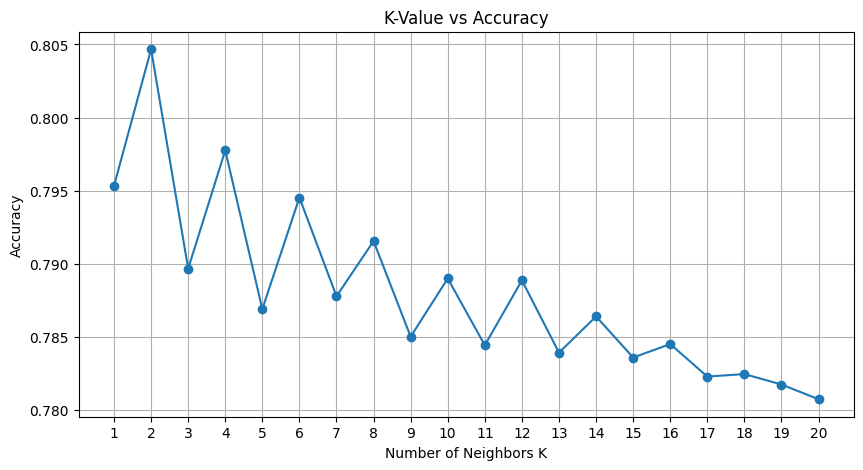

The best k value is: 2 with an accuracy of: 0.8047


In [15]:
bestk=alg.determine_best_K(X, Y)

In [22]:
# Check for unique values
unique_values = data.nunique()
print(unique_values)

hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             6
babies                               5
meal                                 5
country                            178
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
days_in_waiting_list               128
customer_type                        4
adr                      

In [16]:
k_equals2=alg.knn_function(X, Y, 3)
k_equals4=alg.knn_function(X, Y, 5)
k_equals6=alg.knn_function(X, Y, 7)

Accuracy: 78.96808777954602

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83     15033
           1       0.73      0.70      0.71      8845

    accuracy                           0.79     23878
   macro avg       0.78      0.77      0.77     23878
weighted avg       0.79      0.79      0.79     23878


Confusion Matrix [[12697  2336]
 [ 2686  6159]]
Accuracy: 78.69168272049586

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.84     15033
           1       0.73      0.67      0.70      8845

    accuracy                           0.79     23878
   macro avg       0.77      0.76      0.77     23878
weighted avg       0.78      0.79      0.78     23878


Confusion Matrix [[12897  2136]
 [ 2952  5893]]
Accuracy: 78.77962978473909

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87 

In [17]:
crossval_knn5=alg.crossValidation_knn(X, Y, 5, 5)
crossval_knn10=alg.crossValidation_knn(X, Y, 10, 5)

KNN model accuracy with 5-fold cross-validation (in %): 52.19532624172879

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.55      0.59     75166
           1       0.38      0.48      0.43     44224

    accuracy                           0.52    119390
   macro avg       0.51      0.51      0.51    119390
weighted avg       0.55      0.52      0.53    119390

Confusion Matrix
 [[40968 34198]
 [22876 21348]]
KNN model accuracy with 10-fold cross-validation (in %): 51.83599966496356

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.57      0.60     75166
           1       0.37      0.44      0.40     44224

    accuracy                           0.52    119390
   macro avg       0.50      0.50      0.50    119390
weighted avg       0.54      0.52      0.52    119390

Confusion Matrix
 [[42473 32693]
 [24810 19414]]


In [18]:
bootstrap_knn3=alg.bootstrap_knn(X_train, Y_train, X_test, Y_test, 100, 5)


c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Bootstrap Mean Accuracy: 81.33%
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.33      0.45     22478
           1       0.41      0.80      0.54     13339

    accuracy                           0.50     35817
   macro avg       0.57      0.56      0.50     35817
weighted avg       0.61      0.50      0.48     35817

Bootstrap Mean Accuracy:
 [[ 7308 15170]
 [ 2693 10646]]


In [19]:
over_under_samples_knn=alg.oversample_undersample_knn(X, Y, 5)

c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accuracy: 76.58095317865818
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.84      0.78      0.81     22478
           1       0.67      0.74      0.70     13339

    accuracy                           0.77     35817
   macro avg       0.75      0.76      0.75     35817
weighted avg       0.77      0.77      0.77     35817

Confusion Matrix (Oversampled):
 [[17519  4959]
 [ 3429  9910]]


c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accuracy: 76.49161012926822
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.84      0.77      0.80     22478
           1       0.66      0.75      0.70     13339

    accuracy                           0.76     35817
   macro avg       0.75      0.76      0.75     35817
weighted avg       0.77      0.76      0.77     35817

Confusion Matrix (Oversampled):
 [[17356  5122]
 [ 3298 10041]]


In [20]:
holdout_NB=alg.NB_function(X, Y)

Accuracy: 57.17675963927744

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.37      0.52     22478
           1       0.46      0.91      0.61     13339

    accuracy                           0.57     35817
   macro avg       0.67      0.64      0.57     35817
weighted avg       0.72      0.57      0.56     35817


Confusion Matrix
 [[ 8352 14126]
 [ 1212 12127]]


In [21]:
crossval_NB5=alg.crossValidation_NB(X, Y, 5)
crossval_NB10=alg.crossValidation_NB(X, Y, 10)

KNN model accuracy with 5-fold cross-validation (in %): 47.74771756428512

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.21      0.34     75166
           1       0.41      0.93      0.57     44224

    accuracy                           0.48    119390
   macro avg       0.62      0.57      0.45    119390
weighted avg       0.67      0.48      0.42    119390

Confusion Matrix
 [[16047 59119]
 [ 3265 40959]]
KNN model accuracy with 10-fold cross-validation (in %): 46.74093307647206

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.17      0.29     75166
           1       0.41      0.97      0.57     44224

    accuracy                           0.47    119390
   macro avg       0.66      0.57      0.43    119390
weighted avg       0.72      0.47      0.39    119390

Confusion Matrix
 [[12827 62339]
 [ 1247 42977]]


In [22]:
bootstrap_NB=alg.bootstrap_NB(X_train, Y_train, X_test, Y_test, 100)

c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Bootstrap Mean Accuracy: 47.08%
Classification Report:
               precision    recall  f1-score   support

           0       0.63      1.00      0.77     22478
           1       0.00      0.00      0.00     13339

    accuracy                           0.63     35817
   macro avg       0.31      0.50      0.39     35817
weighted avg       0.39      0.63      0.48     35817

Bootstrap Mean Accuracy:
 [[22478     0]
 [13339     0]]


c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [23]:
over_under_samples_NB=alg.oversample_undersample_NB(X, Y)

c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accuracy: 76.58095317865818
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.84      0.78      0.81     22478
           1       0.67      0.74      0.70     13339

    accuracy                           0.77     35817
   macro avg       0.75      0.76      0.75     35817
weighted avg       0.77      0.77      0.77     35817

Confusion Matrix (Oversampled):
 [[17519  4959]
 [ 3429  9910]]


c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accuracy: 76.49161012926822
Classification Report (Undersampled):
               precision    recall  f1-score   support

           0       0.84      0.77      0.80     22478
           1       0.66      0.75      0.70     13339

    accuracy                           0.76     35817
   macro avg       0.75      0.76      0.75     35817
weighted avg       0.77      0.76      0.77     35817

Confusion Matrix (Undersampled):
 [[17356  5122]
 [ 3298 10041]]


In [24]:
holdout_svc=alg.svc_function(X, Y)

Accuracy: 43.61336795376497

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.32      0.41     15033
           1       0.35      0.64      0.46      8845

    accuracy                           0.44     23878
   macro avg       0.48      0.48      0.44     23878
weighted avg       0.51      0.44      0.43     23878


Confusion Matrix [[ 4760 10273]
 [ 3191  5654]]


c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [25]:
crossval_svc5=alg.crossValidation_svc(X, Y, 5)
crossval_svc10=alg.crossValidation_svc(X, Y, 10)

c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

KNN model accuracy with 5-fold cross-validation (in %): 49.601306642097335

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.41      0.50     75166
           1       0.39      0.65      0.49     44224

    accuracy                           0.50    119390
   macro avg       0.53      0.53      0.50    119390
weighted avg       0.56      0.50      0.50    119390

Confusion Matrix
 [[30588 44578]
 [15593 28631]]


c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

KNN model accuracy with 10-fold cross-validation (in %): 53.93500293156881

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.40      0.52     75166
           1       0.43      0.77      0.55     44224

    accuracy                           0.54    119390
   macro avg       0.59      0.59      0.54    119390
weighted avg       0.63      0.54      0.54    119390

Confusion Matrix
 [[30344 44822]
 [10175 34049]]


c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [27]:
bootstrap_svc=alg.bootstrap_scv(X_train, Y_train, X_test, Y_test, 100)


c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-pac

Bootstrap Mean Accuracy: 53.05%
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     22478
           1       0.37      1.00      0.54     13339

    accuracy                           0.37     35817
   macro avg       0.19      0.50      0.27     35817
weighted avg       0.14      0.37      0.20     35817

Bootstrap Mean Accuracy:
 [[    0 22478]
 [    0 13339]]


c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [29]:
over_under_samples_svc=alg.oversample_undersample_scv(X, Y)

c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Accuracy: 39.176927157495044
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.52      0.37      0.43     22478
           1       0.29      0.43      0.35     13339

    accuracy                           0.39     35817
   macro avg       0.41      0.40      0.39     35817
weighted avg       0.43      0.39      0.40     35817

Confusion Matrix (Oversampled):
 [[ 8281 14197]
 [ 7588  5751]]


c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Vasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Accuracy: 54.33453388055951
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.68      0.52      0.59     22478
           1       0.42      0.59      0.49     13339

    accuracy                           0.54     35817
   macro avg       0.55      0.55      0.54     35817
weighted avg       0.58      0.54      0.55     35817

Confusion Matrix (Oversampled):
 [[11648 10830]
 [ 5526  7813]]


In [36]:

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
from Algoritmos import majority_voting_classifiers

# Define classifiers
classifiers = [
    ('knn', KNeighborsClassifier(n_neighbors=3)),
    ('gnb', GaussianNB()),
    ('logreg', LogisticRegression())
]
# Apply majority voting classifiers
y_pred = majority_voting_classifiers(X, Y, classifiers)



c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.768461903565346
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     22550
           1       0.67      0.73      0.70     13267

    accuracy                           0.77     35817
   macro avg       0.75      0.76      0.76     35817
weighted avg       0.77      0.77      0.77     35817



In [37]:
from Algoritmos import weighted_majority_voting_classifiers

# Define classifiers with weights
classifiers = [
    ('knn', KNeighborsClassifier(n_neighbors=3)),
    ('gnb', GaussianNB()),
    ('logreg', LogisticRegression())
]


# Apply weighted majority voting classifiers
y_pred_weighted = weighted_majority_voting_classifiers(X, Y, classifiers)

# Print the predictions
print(y_pred_weighted)

c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7696345310885893
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80     22550
           1       0.66      0.80      0.72     13267

    accuracy                           0.77     35817
   macro avg       0.76      0.78      0.76     35817
weighted avg       0.79      0.77      0.77     35817

0.7696345310885893


In [38]:
from Algoritmos import stacking_logistic_regression

# Define base classifiers
base_classifiers = [
    ('knn', KNeighborsClassifier(n_neighbors=3)),
    ('gnb', GaussianNB()),
    ('logreg', LogisticRegression())
]

# Use the stacking_with_logistic_regression function
stacking_model = stacking_logistic_regression(X, Y, base_classifiers)

# Print the stacking model
print(stacking_model)

c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7846832509702096
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     22550
           1       0.72      0.69      0.70     13267

    accuracy                           0.78     35817
   macro avg       0.77      0.77      0.77     35817
weighted avg       0.78      0.78      0.78     35817

0.7846832509702096


In [35]:
from Algoritmos import stacking_svc
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

base_classifiers = [
    ('knn', KNeighborsClassifier(n_neighbors=3)),
    ('svc', SVC(kernel='linear', probability=True)),  # Set probability=True if needed for stacking
    ('logreg', LogisticRegression())
]

# Use the stacking_svc function
stacking_model_svm = stacking_svc(X, Y, base_classifiers)

# Print the stacking model accuracy
print("Stacking with SVM accuracy:", stacking_model_svm)

c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7846832509702096
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     22550
           1       0.72      0.69      0.70     13267

    accuracy                           0.78     35817
   macro avg       0.77      0.77      0.77     35817
weighted avg       0.78      0.78      0.78     35817

Stacking with SVM accuracy: 0.7846832509702096


In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Initialize the BaggingClassifier with a DecisionTreeClassifier as the base estimator
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)

# Fit the BaggingClassifier on the training data
bagging_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_bagging = bagging_clf.predict(X_test)
accuracy = bagging_clf.score(X_test, y_test)

# Print the classification report
print(classification_report(y_test, y_pred_bagging))
print("Bagging Classifier Accuracy:",accuracy)

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     14907
           1       0.87      0.83      0.85      8971

    accuracy                           0.89     23878
   macro avg       0.89      0.88      0.88     23878
weighted avg       0.89      0.89      0.89     23878

Bagging Classifier Accuracy: 0.8910712790015914


In [40]:
from sklearn.tree import DecisionTreeClassifier
from Algoritmos import boosting_adaboosting

# Defina o classificador base
base_classifier = DecisionTreeClassifier(max_depth=1)

# Use a função boosting_adaboosting com o classificador base
boosting_model = boosting_adaboosting(X, Y, base_classifier=base_classifier)

# O boosting_model retorna a acurácia, conforme a função definida acima
print("Boosting with adaboosting accuracy:", boosting_model)


c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.8210905435966162
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87     22550
           1       0.82      0.66      0.73     13267

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817

Boosting with adaboosting accuracy: 0.8210905435966162


In [41]:
from Algoritmos import boosting_gradient_boosting

# Use the boosting_gradient_boosting function with the X and Y variables
boosting_gb_model = boosting_gradient_boosting(X, Y)

# Print the result
print("Boosting with Gradient Boosting accuracy:", boosting_gb_model)

Accuracy: 0.8431471089147612
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     22550
           1       0.84      0.72      0.77     13267

    accuracy                           0.84     35817
   macro avg       0.84      0.82      0.83     35817
weighted avg       0.84      0.84      0.84     35817

Boosting with Gradient Boosting accuracy: 0.8431471089147612


In [20]:
from Algoritmos import boosting_xgboost

# Use the boosting_xgboost function with the X and Y variables
boosting_xgboost_model = boosting_xgboost(X, Y)

# Print the result
print("Boosting with XGBoost accuracy:", boosting_xgboost_model)

Accuracy: 0.8719881620459559
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     22550
           1       0.85      0.79      0.82     13267

    accuracy                           0.87     35817
   macro avg       0.87      0.86      0.86     35817
weighted avg       0.87      0.87      0.87     35817

Boosting with XGBoost accuracy: 0.8719881620459559


In [25]:
from Algoritmos import boosting_lightgbm

# Use the boosting_lightgbm function with the X and Y variables
boosting_lightgbm_model = boosting_lightgbm(X, Y)

# Print the result
print("Boosting with LightGBM accuracy:", boosting_lightgbm_model)


[LightGBM] [Info] Number of positive: 30957, number of negative: 52616
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 83573, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370419 -> initscore=-0.530421
[LightGBM] [Info] Start training from score -0.530421
Accuracy: 0.8631934556216322
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     22550
           1       0.85      0.77      0.81     13267

    accuracy                           0.86     35817
   macro avg       0.86      0.84      0.85     35817
weighted avg       0.86      0.86      0.86     35817

Boosting with LightGBM accuracy: 0.8631934556216322


In [49]:
# Create a dictionary with model names and their accuracies
model_accuracies = {
    "Bagging Classifier": accuracy,
    "Boosting with AdaBoosting": boosting_model,
    "Boosting with Gradient Boosting": boosting_gb_model,
    "Boosting with XGBoost": boosting_xgboost_model,
    "Boosting with LightGBM": boosting_lightgbm_model,
    "Stacking with Logistic Regression": stacking_model,
    "Stacking with SVM": stacking_model_svm,
    "Majority Voting Classifiers": y_pred,
    "Weighted Majority Voting Classifiers": y_pred_weighted
}

# Sort the dictionary by accuracy
sorted_model_accuracies = dict(sorted(model_accuracies.items(), key=lambda item: item[1], reverse=True))

# Print the accuracies in order
for model, accuracy in sorted_model_accuracies.items():
    print(f"{model}: {accuracy:.4f}")

Bagging Classifier: 0.8911
Boosting with XGBoost: 0.8720
Boosting with LightGBM: 0.8632
Boosting with Gradient Boosting: 0.8431
Boosting with AdaBoosting: 0.8211
Stacking with Logistic Regression: 0.7847
Stacking with SVM: 0.7847
Weighted Majority Voting Classifiers: 0.7696
Majority Voting Classifiers: 0.7685


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize model
input_dim = X_train_scaled.shape[1]  # Number of features in input layer
optimizer = 'adam'  # Example optimizer
neurons = 10  # Number of neurons in each hidden layer

model = alg.nnetClassif(inputDim=input_dim, optimizer=optimizer, neurons=neurons)

# Train model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=10, verbose=1)

# Evaluate the model
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy: {accuracy * 100:.2f}%")